## Retraining 'eye_tracking' model for subject and predicting eye track (pixel coordinate).

In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import pickle
from sklearn.utils import shuffle
from joblib import load as j_load
from joblib import dump as j_dump
import time
import os
import tuning_parameters as tp

In [2]:
# Parameters
path2root = "../"
models_fol = "models/"
models_et_fol = "et/"
trained_fol = "trained/"
subjects_dir = "subjects/"
data_et_fol = "data-et-clb/"
sbj_scalers_boi_fol = "scalers-boi.bin"
sbj_model_boi_fol = "model-boi"
r_train = 0.85
n_epochs = 5
patience = 2
trainable_layers = 1
chosen_inputs = [0, 1, 2, 6, 7, 8, 9]

In [3]:
sbj_dir = path2root + subjects_dir + f"{tp.NUMBER}/"
trained_dir = path2root + models_fol + models_et_fol + trained_fol

### Retraining 'eye_tracking' model with subject calibration data

In [4]:
data_et_dir = sbj_dir + data_et_fol
print(f"\nLoading subject data in {data_et_dir}")
with open(data_et_dir + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(data_et_dir + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(data_et_dir + "y.pickle", "rb") as f:
    y_load = pickle.load(f)
n_smp, frame_h, frame_w = x1_load.shape[:-1]
print(f"Samples number: {n_smp}")


Loading subject data in ../subjects/7/data-et-clb/
Samples number: 60


In [5]:
import matplotlib.pyplot as plt

[ 2.88548892e+00  3.69332781e-02 -2.78162478e-01  2.92375072e+00
 -3.71728999e+00  5.84556838e+01  4.44627553e-01  4.36479121e-01
  4.57284629e-01  4.40449417e-01]
[23 12]


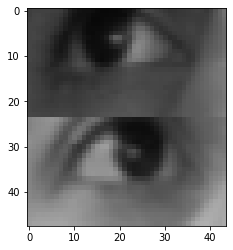

In [6]:
# Displaying data
smp_num = 0
print(x2_load[smp_num])
print(y_load[smp_num])
plt.imshow(x1_load[smp_num].reshape((frame_h, frame_w)),
           cmap="gray", vmin=0, vmax=255)
plt.show()

#### Getting those data that looking 'in' screen

In [7]:
print("\nNormalizing data...")
sbj_scalers_boi_dir = sbj_dir + sbj_scalers_boi_fol
x2_chs_inp = x2_load[:, chosen_inputs]
x1_scaler_boi, x2_scaler_boi = j_load(sbj_scalers_boi_dir)
x1_boi = x1_load / x1_scaler_boi
x2_boi = x2_scaler_boi.transform(x2_chs_inp)


Normalizing data...


In [8]:
print("\nLoading in_blink_out model...")
sbj_model_boi_dir = sbj_dir + sbj_model_boi_fol
model_boi = load_model(sbj_model_boi_dir)
print(model_boi.summary())


Loading in_blink_out model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
_______________________________________________________________

In [9]:
print("\nPredicting those data that looking 'in' screen.")
yhat_boi = model_boi.predict([x1_boi, x2_boi]).argmax(1)


Predicting those data that looking 'in' screen.


In [10]:
# Choosing those data
x1_new = []
x2_new = []
y_new = []
for (x10, x20, y0, yht0) in zip(x1_load, x2_load, y_load, yhat_boi):
    if True: # yht0 != 1:
        x1_new.append(x10)
        x2_new.append(x20)
        y_new.append(y0)

x1_new = np.array(x1_new)
x2_new = np.array(x2_new)
y_new = np.array(y_new)
n_smp_new = x1_new.shape[0]
print(f"New samples: {n_smp_new}")

New samples: 60


### Preparing modified calibration data to feeding in eye_tracking model

In [11]:
print("\nNormalizing modified calibration data to feeding in eye_tracking model...")
public_scalers_et_dir = trained_dir + f"scalers{tp.MODEL_EYE_TRACKING_NUM}.bin"
x2_chs_inp_new = x2_new[:, chosen_inputs]
scalers_et = j_load(public_scalers_et_dir)
x1_scaler_et, x2_scaler_et, _ = scalers_et

x1_nrm = x1_new / x1_scaler_et
x2_nrm = x2_scaler_et.transform(x2_chs_inp_new)

j_dump(scalers_et, sbj_dir + "scalers-et.bin")


Normalizing modified calibration data to feeding in eye_tracking model...


['../subjects/7/scalers-et.bin']

In [12]:
# Shuffling and splitting data to train and test
x1_shf, x2_shf, y_hrz_shf, y_vrt_shf = shuffle(x1_nrm, x2_nrm, y_nrm[:, 0], y_nrm[:, 1])

n_train = int(r_train * n_smp_new)
n_test = n_smp_new - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_hrz_train, y_vrt_train = y_hrz_shf[:n_train], y_vrt_shf[:n_train]
y_hrz_test, y_vrt_test = y_hrz_shf[n_train:], y_vrt_shf[n_train:]

x_train = [x1_train, x2_train]
x_test = [x1_test, x2_test]

print(x1_train.shape, x1_test.shape, y_hrz_train.shape, y_hrz_test.shape,
      x2_train.shape, x2_test.shape, y_vrt_train.shape, y_vrt_test.shape)

(51, 48, 44, 1) (9, 48, 44, 1) (51,) (9,) (51, 7) (9, 7) (51,) (9,)


In [13]:
# Callback for training
cb = EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)

In [14]:
print("Loading public eye_tracking models...")
public_model_et_dir = trained_dir + f"model{tp.MODEL_EYE_TRACKING_NUM}"
model_hrz = load_model(public_model_et_dir + "-hrz")
model_vrt = load_model(public_model_et_dir + "-vrt")
# print(model1.summary())

Loading public eye_tracking models...


In [15]:
for (layer_hrz, layer_vrt) in zip(model_hrz.layers[:-trainable_layers], model_vrt.layers[:-trainable_layers]):
    layer_hrz.trainable = False
    layer_vrt.trainable = False

print(model_hrz.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 44, 16)   416         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 22, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [16]:
print("\nStart of training for model 1 (x-pixels)")
results_hrz = model_hrz.fit(x_train,
                            y_hrz_train,
                            validation_data=(x_test, y_hrz_test),
                            epochs=n_epochs,
                            callbacks=cb)
print("End of training")


Start of training for model 1 (x-pixels)
Epoch 1/5
2/2 [==============================] - 1s 191ms/step - loss: 0.1478 - val_loss: 0.0714
Epoch 2/5
2/2 [==============================] - 0s 58ms/step - loss: 0.0844 - val_loss: 0.0444
Epoch 3/5
2/2 [==============================] - 0s 53ms/step - loss: 0.0459 - val_loss: 0.0466
Epoch 4/5
2/2 [==============================] - 0s 65ms/step - loss: 0.0578 - val_loss: 0.0180
Epoch 5/5
2/2 [==============================] - 0s 71ms/step - loss: 0.0306 - val_loss: 0.0525
End of training


In [17]:
print("\nStart of training for model 2 (y-pixels)")
results_vrt = model_vrt.fit(x_train,
                            y_vrt_train,
                            validation_data=(x_test, y_vrt_test),
                            epochs=n_epochs,
                            callbacks=cb)
print("End of training")


Start of training for model 2 (y-pixels)
Epoch 1/5
2/2 [==============================] - 1s 166ms/step - loss: 0.3323 - val_loss: 0.3317
Epoch 2/5
2/2 [==============================] - 0s 58ms/step - loss: 0.3316 - val_loss: 0.3316
Epoch 3/5
2/2 [==============================] - 0s 54ms/step - loss: 0.3316 - val_loss: 0.3318
Epoch 4/5
2/2 [==============================] - 0s 58ms/step - loss: 0.3318 - val_loss: 0.3317
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
End of training


In [19]:
print("\nSaving models...")
model_hrz.save(sbj_dir + "model-et-hrz")
model_vrt.save(sbj_dir + "model-et-vrt")


Saving models...
INFO:tensorflow:Assets written to: ../subjects/7/model-et-hrz\assets
INFO:tensorflow:Assets written to: ../subjects/7/model-et-vrt\assets


In [20]:
# Predicting outputs for train and test data
y_hrz_hat_train = model_hrz.predict(x_train).reshape((n_train,))
y_hrz_hat_test = model_hrz.predict(x_test).reshape((n_test,))
y_vrt_hat_train = model_vrt.predict(x_train).reshape((n_train,))
y_vrt_hat_test = model_vrt.predict(x_test).reshape((n_test,))

In [21]:
min_out_ratio = 0.005
max_out_ratio = 0.995

y_hrz_hat_train[y_hrz_hat_train < min_out_ratio] = min_out_ratio
y_hrz_hat_test[y_hrz_hat_test < min_out_ratio] = min_out_ratio
y_vrt_hat_train[y_vrt_hat_train < min_out_ratio] = min_out_ratio
y_vrt_hat_test[y_vrt_hat_test < min_out_ratio] = min_out_ratio

y_hrz_hat_train[y_hrz_hat_train > max_out_ratio] = max_out_ratio
y_hrz_hat_test[y_hrz_hat_test > max_out_ratio] = max_out_ratio
y_vrt_hat_train[y_vrt_hat_train > max_out_ratio] = max_out_ratio
y_vrt_hat_test[y_vrt_hat_test > max_out_ratio] = max_out_ratio

Train
(2219, 12)
(2384, 1001)
Test
(3816, 999)
(3742, 1001)


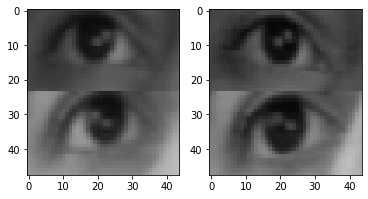

In [22]:
# Displaying data
smp_num = 0
y_scalers_et = np.array([1280, 720])
print("Train")
sample_train = (int(y_hrz_train[smp_num] * y_scalers_et[0]),
                int(y_vrt_train[smp_num] * y_scalers_et[1]))
sample_hat_train = (int(y_hrz_hat_train[smp_num] * y_scalers_et[0]),
                    int(y_vrt_hat_train[smp_num] * y_scalers_et[1]))
print(sample_train)
print(sample_hat_train)

print("Test")
sample_test = (int(y_hrz_test[smp_num] * y_scalers_et[0]),
               int(y_vrt_test[smp_num] * y_scalers_et[1]))
sample_hat_test = (int(y_hrz_hat_test[smp_num] * y_scalers_et[0]),
                   int(y_vrt_hat_test[smp_num] * y_scalers_et[1]))
print(sample_test)
print(sample_hat_test)

_, ax = plt.subplots(1, 2)
ax[0].imshow((x1_train[smp_num] * x1_scaler_et).astype(np.uint8).
             reshape((frame_h, frame_w)), cmap="gray", vmin=0, vmax=255)
ax[1].imshow((x1_test[smp_num] * x1_scaler_et).astype(np.uint8).
             reshape((frame_h, frame_w)), cmap="gray", vmin=0, vmax=255)